<a href="https://colab.research.google.com/github/breathmark/3253-Machine-Learning/blob/main/3253_Term_Project_Notebook_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3253 Final Term Project


For our final project we will be using a data-set from kaggle to detect cyber intrusion. The dataset can be found here: https://www.kaggle.com/datasets/mohamedamineferrag/edgeiiotset-cyber-security-dataset-of-iot-iiot (Links to an external site.) There are two set of file. We have used one as a validation dataset which is opposite that of traning set (term of balance).

The train dataset has a total of 2,219,201 (73%) records with 603,558 (27%) of them being malicious, which is indicated by the Attack_label and type columns. In total the data consists of 63 columns. Some of these columns includes textual information such as description, requirements, and benefits. We will perform various analysis on all of these 63 columns to pick those that will give the best possible unsupervised model that can predict any malicious attack.

- Adam Hoehne
- Athar Syed
- Piranavan Satkunanathan (Arun)
- Tanmay Bhise
- Yingying Zheng (Sara)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#from flashtext import KeywordProcessor
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import warnings
from sklearn.utils import shuffle
import random
#import plotly.express as px
random.seed(42)

# Loading of the datasets

In [ ]:
# here we assume both of the datasets are in the /datasets folder
df = pd.read_csv('./datasets/DNN-EdgeIIoT-dataset.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,3,6,11,13,14,15,16,17,31,32,34,39,45,51,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# since the dataset is huge we use samples due to limited resources, can commment this code below if resources are avaialble
# to process 1.2GB dataset

df = df.groupby("Attack_type", group_keys = False, as_index = True).apply(lambda x: x.sample(frac = .05))

In [ ]:
df.head(5)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
1961317,2021 20:56:04.254688000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1,Backdoor
1962796,2021 21:01:32.729239000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1,Backdoor
1950636,2021 20:16:16.410622000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1,Backdoor
1955810,2021 20:35:37.283624000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1,Backdoor
1945974,2021 18:23:29.910329000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0,0,0.0,0.0,0.0,0.0,0.0,1,Backdoor


In [ ]:
# dimensionality of the dataset 
display(df.shape)

(110961, 63)

In [ ]:
# show column names, types, and number of instances
df.info() # 2.2+ million rows, 43 numeric columns, 20 categorical columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110961 entries, 1961317 to 1976708
Data columns (total 63 columns):
frame.time                   110961 non-null object
ip.src_host                  110961 non-null object
ip.dst_host                  110961 non-null object
arp.dst.proto_ipv4           110961 non-null object
arp.opcode                   110961 non-null float64
arp.hw.size                  110961 non-null float64
arp.src.proto_ipv4           110961 non-null object
icmp.checksum                110961 non-null float64
icmp.seq_le                  110961 non-null float64
icmp.transmit_timestamp      110961 non-null float64
icmp.unused                  110961 non-null float64
http.file_data               110961 non-null object
http.content_length          110961 non-null float64
http.request.uri.query       110961 non-null object
http.request.method          110961 non-null object
http.referer                 110961 non-null object
http.request.full_uri        110961 non-nul

In [ ]:
# descriptive statistic on numeric features
df.describe()

,arp.opcode,arp.hw.size,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,icmp.unused,http.content_length,http.response,http.tls_port,tcp.ack,...,mqtt.len,mqtt.msg_decoded_as,mqtt.msgtype,mqtt.proto_len,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label
count,110961.000000,110961.000000,110961.000000,110961.000000,1.109610e+05,110961.0,110961.000000,110961.000000,110961.0,1.109610e+05,...,110961.000000,110961.0,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000,110961.000000
mean,0.002992,0.014762,1709.484449,1887.150458,2.779021e+03,0.0,4.761304,0.014726,0.0,2.219461e+07,...,1.999793,0.0,0.744631,0.152198,0.903453,0.152198,0.000622,0.002190,0.000081,0.271978
std,0.063613,0.297245,8458.483106,8879.040368,4.628518e+05,0.0,54.856165,0.120454,0.0,1.614276e+08,...,7.673784,0.0,2.689324,0.765266,4.568022,0.765266,0.098243,0.352436,0.013757,0.444981
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,1.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,6.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,5.900000e+01,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2.000000,6.000000,65522.000000,65528.000000,7.721411e+07,0.0,1465.000000,1.000000,0.0,3.949529e+09,...,39.000000,0.0,14.000000,4.000000,24.000000,4.000000,21.000000,77.000000,4.000000,1.000000


In [ ]:
# dataset distribution by the "Attack_label" column
round(df['Attack_label'].value_counts()/len(df)*100, 2)

0    72.8
1    27.2
Name: Attack_label, dtype: float64

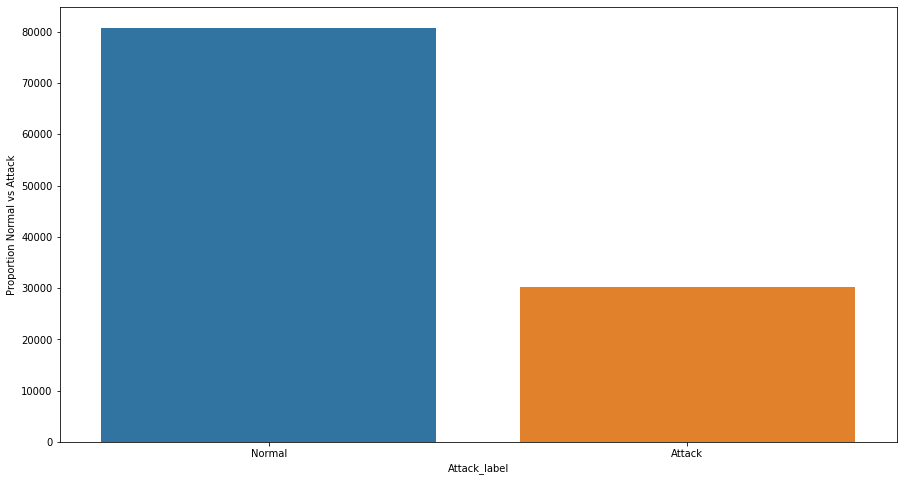

In [ ]:
# how balance is the dataset
def check_balance(df, target):
    plt.figure(figsize = (15,8))
    sns.countplot(x = target, data=df)
    plt.xticks(np.arange(2),('Normal', 'Attack'))
    plt.ylabel('Proportion Normal vs Attack')
    plt.show()

check_balance(df, 'Attack_label')

In [ ]:
# dataset distribution by categorical column "Attack_type"
round(df['Attack_type'].value_counts()/len(df)*100, 2)

Normal                   72.80
DDoS_UDP                  5.48
DDoS_ICMP                 5.25
SQL_injection             2.31
Password                  2.26
Vulnerability_scanner     2.26
DDoS_TCP                  2.26
DDoS_HTTP                 2.25
Uploading                 1.70
Backdoor                  1.12
Port_Scanning             1.02
XSS                       0.72
Ransomware                0.49
MITM                      0.05
Fingerprinting            0.05
Name: Attack_type, dtype: float64

# Features Analysis

In [ ]:
# display percentage of any missing data
def missing_data_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent_1 = df.isnull().sum()/df.isnull().count()*100
    percent_2 = (round(percent_1, ndigits = 2)).sort_values(ascending = False)
    missing_data = pd.concat([total, percent_2], axis = 1, keys = ['Total', '%'], sort = True)
    return missing_data   

missing_data_percentage(df)

,Total,%
Attack_label,0,0.0
Attack_type,0,0.0
arp.dst.proto_ipv4,0,0.0
arp.hw.size,0,0.0
arp.opcode,0,0.0
...,...,...
tcp.seq,0,0.0
tcp.srcport,0,0.0
udp.port,0,0.0
udp.stream,0,0.0


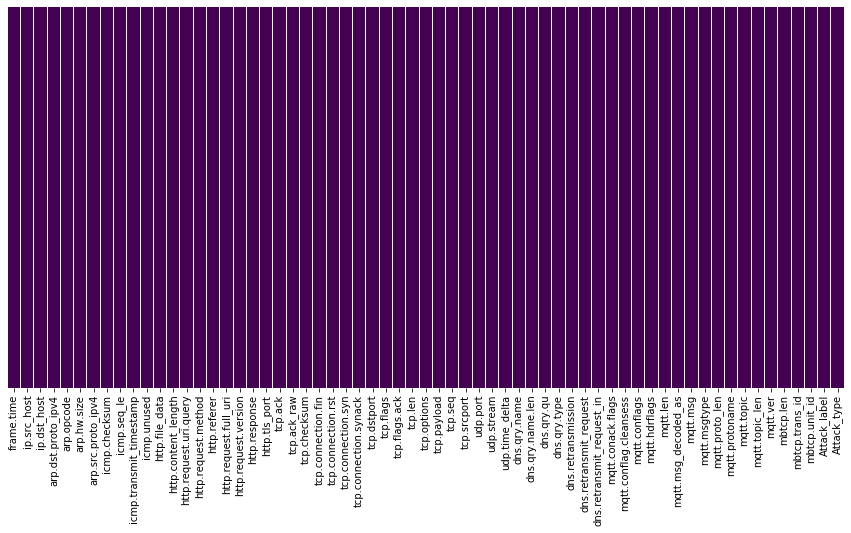

In [ ]:
# Looks like there are no missing data. Just for visualization :
# In yellow one can better visualize how missing data are spread within each categorical variable.
plt.figure(figsize = (15, 7))
sns.heatmap(df.isnull(), cbar = False, yticklabels = False, cmap = 'viridis' )
plt.show()

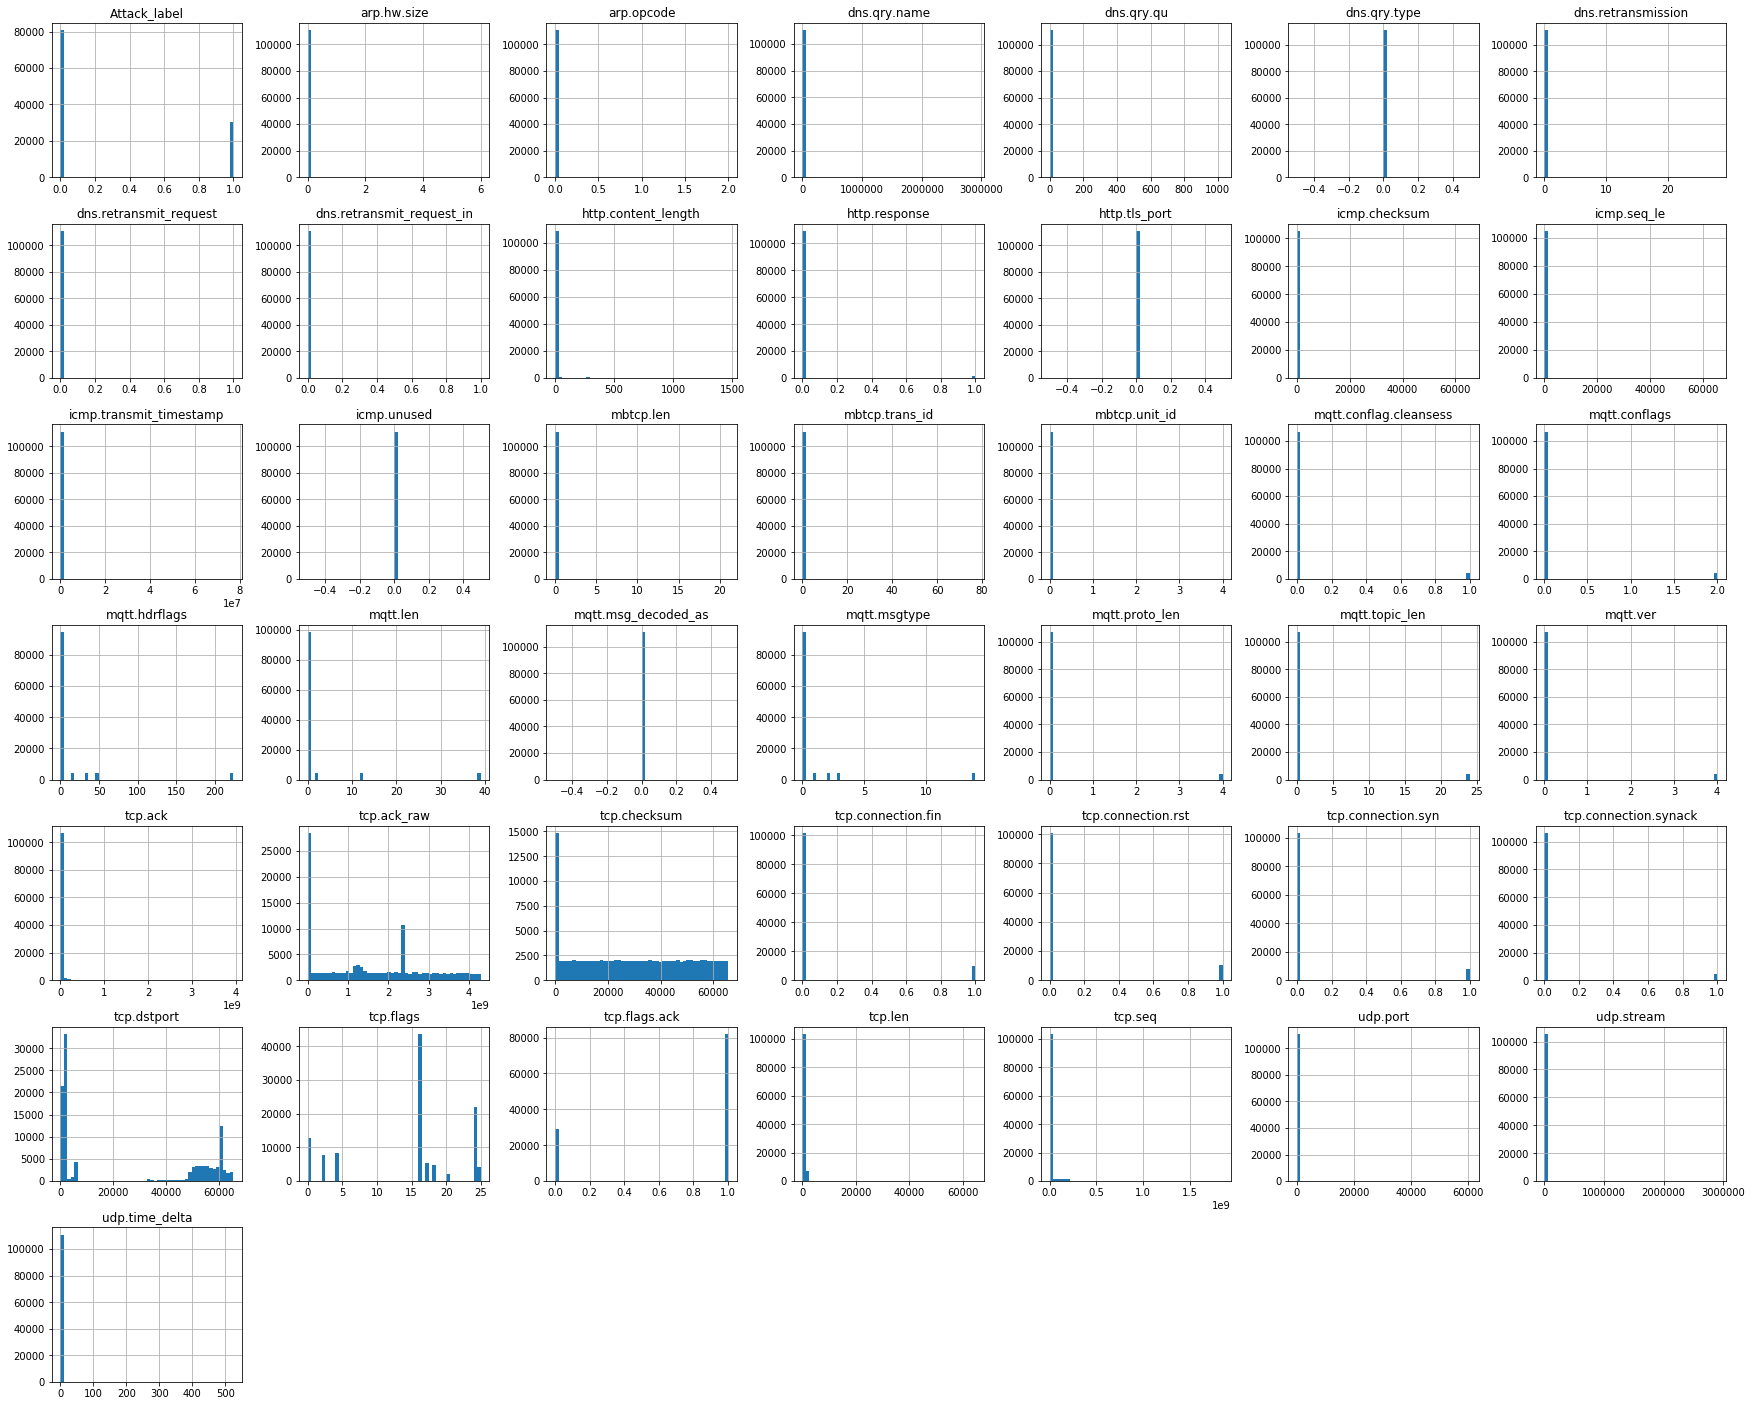

In [ ]:
# distrubtions of numeric features
df.hist(bins=50, figsize=(30,25))
plt.show()

In [ ]:
# drop features with one value
nunique = df.nunique() # no features with only one value

cols_to_drop=nunique[nunique == 1].index # delete as there is no feature with 1 value
print(cols_to_drop)

Index(['icmp.unused', 'http.tls_port', 'dns.qry.type', 'mqtt.msg_decoded_as'], dtype='object')


In [ ]:
df.drop(cols_to_drop, axis=1, inplace=True)
display(df.shape)

(110961, 59)

In [ ]:
# correlation matrix 
corr_matrix = df.corr()

In [ ]:
# Investigate numeric feature multi collinearity 
def multi_collinearity_heatmap(df, figsize=(30,20)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

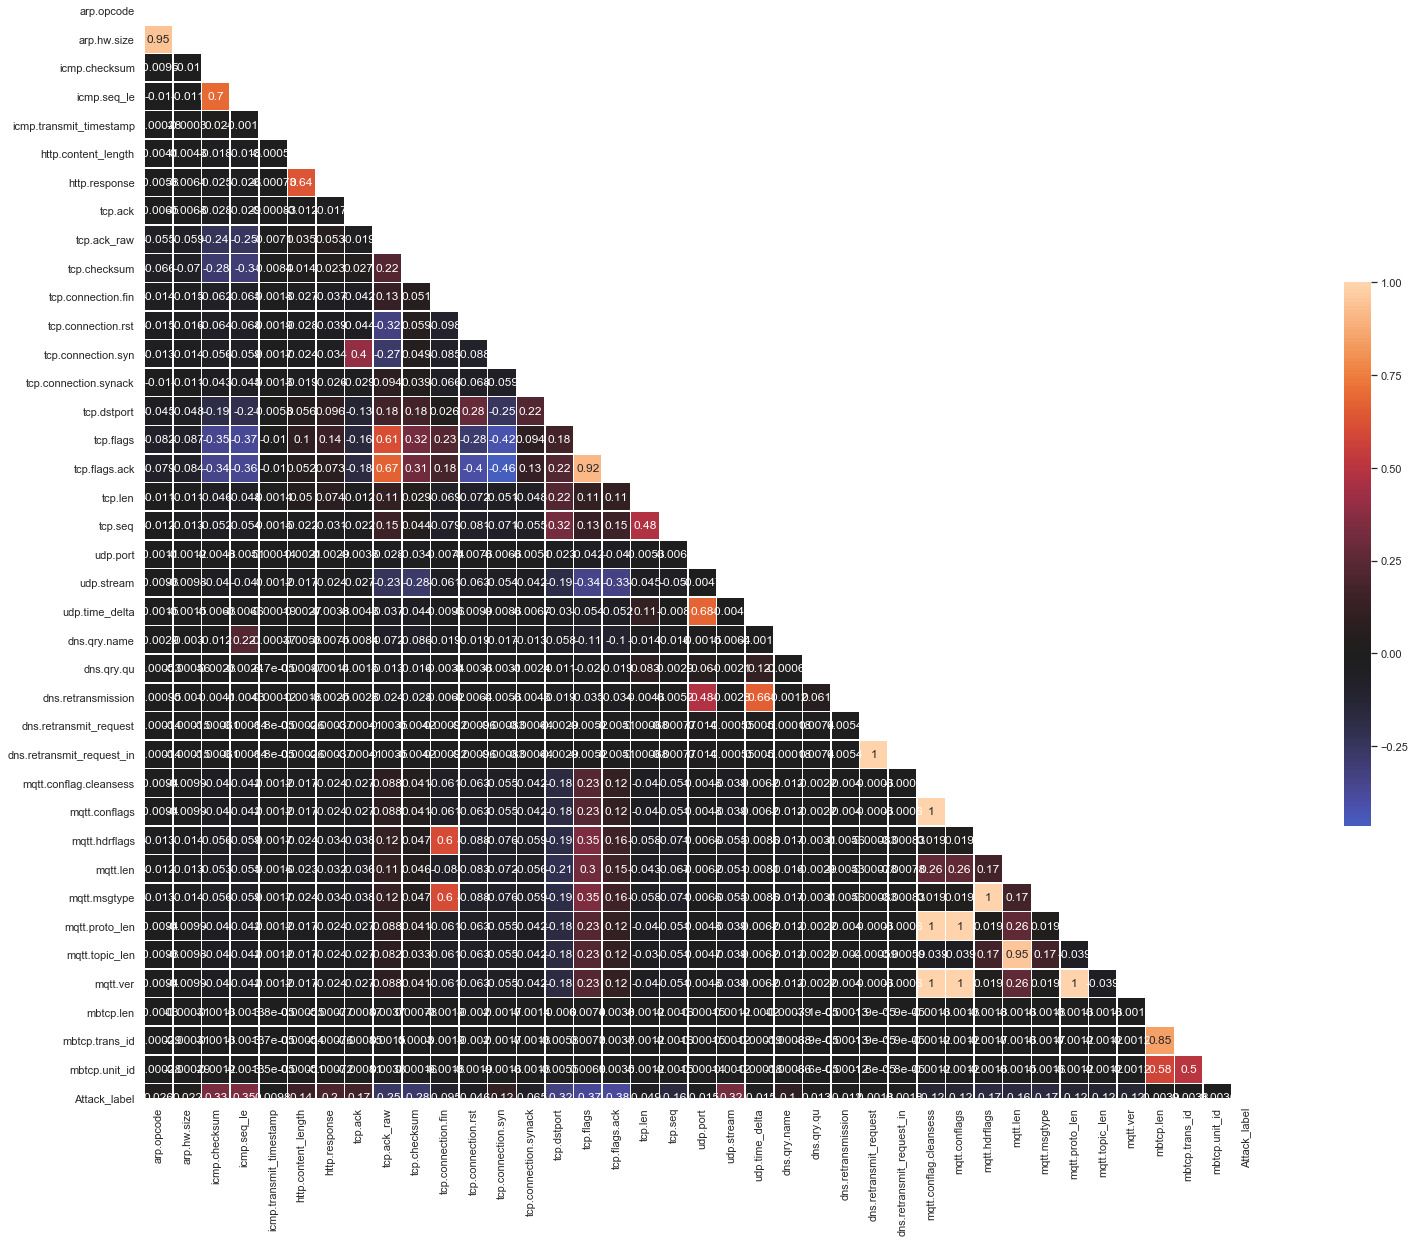

In [ ]:
# Graph of correlation matrix
multi_collinearity_heatmap(df)

In [ ]:
# this function will give you the correlation among two features with a given threshold
def correlation_by_threshold(dataset, threshold):
    col_combo_corr = set() # set of column combination and the coefficients
    corr_matrix = dataset.corr().abs() # absolute to get the negatively correlated features as well
    col_corr = set() # set to drop if needed
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold):
                colname = corr_matrix.columns[i] + " & " + corr_matrix.columns[j] + ":" + str(corr_matrix.iloc[i, j])# getting the name of columns
                col_combo_corr.add(colname)
                if ((corr_matrix.columns[j] not in col_corr)):
                    col_corr.add(corr_matrix.columns[i])
    return col_combo_corr, col_corr

In [ ]:
# get features that have Pearson correlation coeff > .65
corr_column_drop = correlation_by_threshold(df,0.65)
corr_column_drop

({'arp.hw.size & arp.opcode:0.9470991931819724',
  'dns.retransmission & udp.time_delta:0.6631943931250797',
  'dns.retransmit_request_in & dns.retransmit_request:1.0',
  'icmp.seq_le & icmp.checksum:0.6994383197776355',
  'mbtcp.trans_id & mbtcp.len:0.8456292228378305',
  'mqtt.conflags & mqtt.conflag.cleansess:1.0',
  'mqtt.msgtype & mqtt.hdrflags:1.0',
  'mqtt.proto_len & mqtt.conflag.cleansess:1.0',
  'mqtt.proto_len & mqtt.conflags:1.0',
  'mqtt.topic_len & mqtt.len:0.9536207550188252',
  'mqtt.ver & mqtt.conflag.cleansess:1.0',
  'mqtt.ver & mqtt.conflags:1.0',
  'mqtt.ver & mqtt.proto_len:1.0',
  'tcp.flags.ack & tcp.ack_raw:0.6692489655825317',
  'tcp.flags.ack & tcp.flags:0.9167937631655191',
  'udp.time_delta & udp.port:0.6838737117404796'},
 {'arp.hw.size',
  'dns.retransmit_request_in',
  'icmp.seq_le',
  'mbtcp.trans_id',
  'mqtt.conflags',
  'mqtt.msgtype',
  'mqtt.proto_len',
  'mqtt.topic_len',
  'mqtt.ver',
  'tcp.flags.ack',
  'udp.time_delta'})

In [ ]:
# remove those features that have correlation greater than .65
df.drop(corr_column_drop[1], axis=1, inplace=True)
df.shape # dropped 11 numeric features

(110961, 48)

In [ ]:
# list of numeric columns
df_num = df.select_dtypes(exclude = 'object')
features_df_num= df_num.columns[:-1] # exclude "Attack_label"
print("The", len(features_df_num), "numeric features are: ", features_df_num)

The 27 numeric features are:  Index(['arp.opcode', 'icmp.checksum', 'icmp.transmit_timestamp',
       'http.content_length', 'http.response', 'tcp.ack', 'tcp.ack_raw',
       'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport',
       'tcp.flags', 'tcp.len', 'tcp.seq', 'udp.port', 'udp.stream',
       'dns.qry.name', 'dns.qry.qu', 'dns.retransmission',
       'dns.retransmit_request', 'mqtt.conflag.cleansess', 'mqtt.hdrflags',
       'mqtt.len', 'mbtcp.len', 'mbtcp.unit_id'],
      dtype='object')


### Categorical features

In [ ]:
# list of categorical features
df_cat = df.select_dtypes(include = ['object'])
features_df_cat = df_cat.columns[: -1] # exclude "Attack_type" label
print("The", len(features_df_cat), "categorical features are: ", features_df_cat)

The 19 categorical features are:  Index(['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4',
       'arp.src.proto_ipv4', 'http.file_data', 'http.request.uri.query',
       'http.request.method', 'http.referer', 'http.request.full_uri',
       'http.request.version', 'tcp.options', 'tcp.payload', 'tcp.srcport',
       'dns.qry.name.len', 'mqtt.conack.flags', 'mqtt.msg', 'mqtt.protoname',
       'mqtt.topic'],
      dtype='object')


In [ ]:
# infer categorical feature data type
for column in features_df_cat:
  print(column, ":", pd.api.types.infer_dtype(df_cat[column])) # show mixed data types that needs cleaning

frame.time : string
ip.src_host : string
ip.dst_host : mixed-integer
arp.dst.proto_ipv4 : mixed-integer
arp.src.proto_ipv4 : mixed-integer
http.file_data : mixed
http.request.uri.query : mixed
http.request.method : mixed-integer
http.referer : mixed-integer
http.request.full_uri : mixed-integer
http.request.version : mixed-integer
tcp.options : mixed
tcp.payload : mixed
tcp.srcport : mixed
dns.qry.name.len : mixed-integer
mqtt.conack.flags : mixed
mqtt.msg : mixed
mqtt.protoname : mixed
mqtt.topic : mixed


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### frame.time : Request Arrival Time

In [ ]:
df['frame.time'].value_counts()

192.168.0.128                550
0.0                           46
6.0                           15
 2021 17:49:05.038958000       1
 2021 17:33:33.358995000       1
                            ... 
 2021 15:56:56.625459000       1
 2021 19:48:29.319344000       1
 2021 23:09:28.105247000       1
 2021 11:36:41.114099000       1
 2021 17:55:50.570750000       1
Name: frame.time, Length: 110353, dtype: int64

In [ ]:
# this column is not clean, here we have bad entry such as entry that are not related to time
# can you regular expression to get the time

df['frame.time_clean'] =  np.where(df['frame.time'].str.contains('[0-9]{4} [0-9]{2}:[0-9]{2}.')
                                              , df['frame.time'].str[6:8]
                                              , np.NaN)

# there are small number of records with wrongly formated dates
df['frame.time_clean'] =  np.where(df['frame.time_clean'].str.contains(":")
                                              , np.NaN
                                              , df['frame.time_clean'])

In [ ]:
df['frame.time_clean'].value_counts()

19    23463
21    11261
20    10240
17     9649
18     9258
16     9194
23     8478
22     6721
15     4378
11     3258
12     2893
13     2836
14     2821
01      254
00      117
Name: frame.time_clean, dtype: int64

In [ ]:
# fillna with the most frequent time "19"####
df['frame.time_clean'].fillna('19', inplace = True)

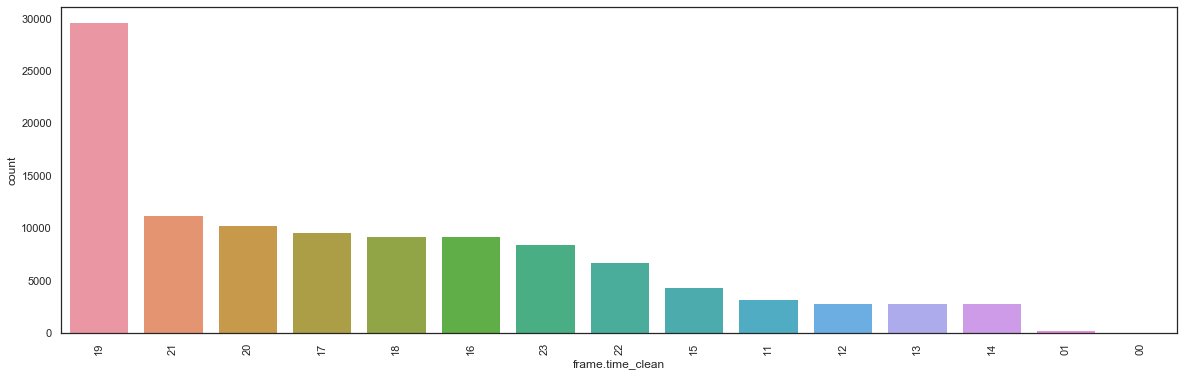

In [ ]:
plt.figure(figsize=(20,6))
ax = sns.countplot(x='frame.time_clean', data= df, order = df['frame.time_clean'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
df['frame.time_clean'].isna().sum()

0

### ip.src_host

In [ ]:
df['ip.src_host'].value_counts()

192.168.0.128     48262
192.168.0.101     33159
0                 14328
192.168.0.170      8301
0.0.0.0              49
                  ...  
193.95.0.51           1
221.212.30.27         1
214.55.180.144        1
0.213.77.173          1
59.108.18.202         1
Name: ip.src_host, Length: 6822, dtype: int64

In [ ]:
# Here we can use api such as http://ip-api.com/json/ to get geo-data location. However, looks like the dataset ips are mock ips

In [ ]:
# convert the column dtype to string
df['ip.src_host']= df['ip.src_host'].map(str)
pd.api.types.infer_dtype(df['ip.src_host'])

'string'

In [ ]:
# consolidate 0 strings
df['ip.src_host_clean'] =  np.where(df['ip.src_host'].str.contains('^00*')
                                              , "0"
                                              , df['ip.src_host'])

In [ ]:
df['ip.src_host_clean'].value_counts()

192.168.0.128      48262
192.168.0.101      33159
0                  14415
192.168.0.170       8301
192.168.0.1           33
                   ...  
236.111.132.100        1
160.197.22.101         1
160.93.4.20            1
182.212.153.209        1
59.108.18.202          1
Name: ip.src_host_clean, Length: 6783, dtype: int64

### ip.dst_host

In [ ]:
df['ip.dst_host']=df['ip.dst_host'].map(str)
pd.api.types.infer_dtype(df['ip.dst_host'])

'string'

In [ ]:
# consolidate 0 strings
df['ip.dst_host_clean'] = np.where(df['ip.dst_host'].str.contains('^00*'), '0', df['ip.dst_host'])

In [ ]:
df['ip.dst_host_clean'].value_counts()

192.168.0.128     47760
192.168.0.101     33394
0                 19877
192.168.0.170      7135
224.0.0.251          61
                  ...  
166.170.11.34         1
25.205.13.133         1
38.127.141.122        1
73.52.105.122         1
1.146.21.25           1
Name: ip.dst_host_clean, Length: 2629, dtype: int64

### arp.src.proto_ipv4

In [ ]:
df['arp.src.proto_ipv4'].value_counts()

0                79537
0                30754
0.0                397
192.168.0.1        152
192.168.0.128       71
192.168.0.170       46
192.168.0.101        3
0.0.0.0              1
Name: arp.src.proto_ipv4, dtype: int64

In [ ]:
df['arp.src.proto_ipv4']=df['arp.src.proto_ipv4'].map(str)
pd.api.types.infer_dtype(df['arp.src.proto_ipv4'])

'string'

In [ ]:
df['arp.src.proto_ipv4_clean'] = np.where(df['arp.src.proto_ipv4'].str.contains('^00*'), '0', df['arp.src.proto_ipv4'])

In [ ]:
df['arp.src.proto_ipv4_clean'].value_counts() # majority of the instances are 0

0                110689
192.168.0.1         152
192.168.0.128        71
192.168.0.170        46
192.168.0.101         3
Name: arp.src.proto_ipv4_clean, dtype: int64

#### http.request.method :

In [ ]:
df['http.request.method'].value_counts()

0          96247
0           9630
0.0         3452
GET         1564
POST          54
TRACE         13
OPTIONS        1
Name: http.request.method, dtype: int64

In [ ]:
df['http.request.method'].isnull().sum()

0

In [ ]:
# combine both 0 and 0.0
df['http.request.method']=df['http.request.method'].map(str)
pd.api.types.infer_dtype(df['http.request.method'])

'string'

In [ ]:
df['http.request.method_clean'] = np.where(df['http.request.method'].str.contains('^00*'), '0', df['http.request.method'])

In [ ]:
df['http.request.method_clean'].value_counts()

0          109329
GET          1564
POST           54
TRACE          13
OPTIONS         1
Name: http.request.method_clean, dtype: int64

In [ ]:
df['http.request.method_clean'].isnull().sum()

0

####  http.request.version :

In [ ]:
df['http.request.version'].value_counts()

0                                      96247
0                                       9691
0.0                                     3391
HTTP/1.1                                1453
HTTP/1.0                                 177
/etc/passwd|?data=Download HTTP/1.1        1
-a HTTP/1.1                                1
Name: http.request.version, dtype: int64

In [ ]:
# combine both 0 and 0.0
df['http.request.version'] = df['http.request.version'].map(str)
pd.api.types.infer_dtype(df['http.request.version'])

'string'

In [ ]:
df['http.request.version_clean'] = np.where(df['http.request.version'].str.contains('^00*'), '0', df['http.request.version'])

In [ ]:
df['http.request.version_clean'].value_counts()

0                                      109329
HTTP/1.1                                 1453
HTTP/1.0                                  177
/etc/passwd|?data=Download HTTP/1.1         1
-a HTTP/1.1                                 1
Name: http.request.version_clean, dtype: int64

In [ ]:
df['http.request.version_clean'].isnull().sum()

0

#### HTTPS character string. There are multiple columns with http request inludes :
['http.file_data', 'http.request.uri.query', 'http.referer', 'http.request.full_uri']

### http.file_data

In [ ]:
df['http.file_data'].value_counts()

0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

#### The long-text categories describe above impose a challenge to extract important information among thousands of words, while avoiding overfitting the model.

#### With those hurdles in mind, we will approach this problem as follows.

#### 1 - Combine all rows into one single block of text for each categorical variable.
#### 2 - Remove punctuation, special characters, multiple spaces and stop words.
#### 3 - Vectorize the texts to extract the frequency of the words.

In [ ]:
# concat text
def combine_text(list_of_text):
    combined_text = " ".join(list_of_text)
    return combined_text

# Clean text (Remove punctuation, special characters, multiple spaces and stop words.)
def clean_text_round1(text):
    
    text = text.lower()
    text = re.sub('\[.*\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('['' “” ... •]', ' ', text)
    text = re.sub('\n', '', text)
    text = text.replace(u'\xa0', u'')
    return text
round1 = lambda x: clean_text_round1(x)

In [ ]:
# this funcation will combine the columns, remove unwanted characters and vectorize to show the frequency of requested index
def get_frequency_of_words(df,columns, col):
    for i in df[columns]:
        df[i] = df[i].str.strip()
        
    texts =  df[columns].fillna('text_not_informed')
    combined_columns = []
    for column in columns:
    
        list_of_text = [str(text) for text in df[column] if str(text).isalpha]
        combined_columns.append(list_of_text)


    list_of_columns = [combine_text(text) for text in combined_columns]
    texts = pd.DataFrame(list_of_columns)
    index = columns
    texts['index']=columns
    round1 = lambda x: clean_text_round1(x)
    texts = texts.set_index('index')
    texts.rename(columns = {0:'Texts'}, inplace = True)
    data_clean = pd.DataFrame(texts.Texts.apply(round1))
    cv = CountVectorizer(stop_words = 'english')
    data_cv = cv.fit_transform(data_clean.Texts)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names())
    data_dtm.index = data_clean.index
    data = data_dtm.T
    
    request_text = pd.DataFrame(data[col].sort_values(ascending = False).head(30)).reset_index()
    request_text.columns = ['words', 'frequency']
    
    profile = pd.DataFrame(request_text)
    rel_freq = []

    for freq in profile['frequency']:
        score = (freq/profile['frequency'].sum()).round(decimals = 2)
        rel_freq.append(score)

    profile['rel_freq'] = rel_freq
    return profile

In [ ]:
get_frequency_of_words(df,['http.file_data', 'http.request.uri.query', 'http.referer', 'http.request.full_uri'],
                       'http.file_data')

,words,frequency,rel_freq
0,nan,99470,0.87
1,br,1637,0.01
2,div,1516,0.01
3,html,1176,0.01
4,id,931,0.01
5,login,802,0.01
6,type,697,0.01
7,dvwa,696,0.01
8,body,591,0.01
9,head,588,0.01


In [ ]:
# looking at these we can just drop them. They dont seems to have much common to the problem we are trying to resolve
# Also drop other columns that dont seem to be an interest to the problem
# They categorical features were drop since they dont give addtional detail. All ip address are private and wont be useful. The
features_to_drop =["frame.time", "ip.src_host", "ip.dst_host", "arp.src.proto_ipv4","ip.src_host_clean", "ip.dst_host_clean", 
                   
                    "http.request.method", "http.request.version","arp.src.proto_ipv4_clean","arp.dst.proto_ipv4", 

                     "http.file_data","http.request.full_uri","icmp.transmit_timestamp", "http.referer",

                     "http.request.uri.query", "tcp.options","tcp.payload","tcp.srcport",

                     "tcp.dstport", "udp.port", "mqtt.msg", "dns.qry.name.len", "mqtt.conack.flags", 
               
                      "mqtt.protoname", "mqtt.topic"]

In [ ]:
df.drop(features_to_drop, axis=1, inplace=True)
display(df.shape)

(110961, 29)

In [ ]:
# cleaned dataset has 23 numeric features and 4 categorical features
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110961 entries, 1961317 to 1976708
Data columns (total 29 columns):
arp.opcode                    110961 non-null float64
icmp.checksum                 110961 non-null float64
http.content_length           110961 non-null float64
http.response                 110961 non-null float64
tcp.ack                       110961 non-null float64
tcp.ack_raw                   110961 non-null float64
tcp.checksum                  110961 non-null float64
tcp.connection.fin            110961 non-null float64
tcp.connection.rst            110961 non-null float64
tcp.connection.syn            110961 non-null float64
tcp.connection.synack         110961 non-null float64
tcp.flags                     110961 non-null float64
tcp.len                       110961 non-null float64
tcp.seq                       110961 non-null float64
udp.stream                    110961 non-null float64
dns.qry.name                  110961 non-null float64
dns.qry.qu        

In [ ]:
# one hot encode
df= pd.get_dummies(df,
                         columns = ["frame.time_clean", "http.request.method_clean", "http.request.version_clean"],
                         prefix=["frame.time_clean", "http.request.method_clean", "http.request.version_clean"])

### Prepare labels for scaling and split

In [ ]:
# separate all numeric feature labels
df_num = df.select_dtypes(include = "float64")
features_num = list(df_num.columns)

In [ ]:
# thoughts on scaling: the numeric features have disparate data distribution profile
# some binary,some with skewed distributions
df_num.max() - df_num.min()

arp.opcode                2.000000e+00
icmp.checksum             6.552200e+04
http.content_length       1.465000e+03
http.response             1.000000e+00
tcp.ack                   3.949529e+09
tcp.ack_raw               4.294923e+09
tcp.checksum              6.553500e+04
tcp.connection.fin        1.000000e+00
tcp.connection.rst        1.000000e+00
tcp.connection.syn        1.000000e+00
tcp.connection.synack     1.000000e+00
tcp.flags                 2.500000e+01
tcp.len                   6.471900e+04
tcp.seq                   1.847300e+09
udp.stream                2.898761e+06
dns.qry.name              2.896157e+06
dns.qry.qu                1.028000e+03
dns.retransmission        2.800000e+01
dns.retransmit_request    1.000000e+00
mqtt.conflag.cleansess    1.000000e+00
mqtt.hdrflags             2.240000e+02
mqtt.len                  3.900000e+01
mbtcp.len                 2.100000e+01
mbtcp.unit_id             4.000000e+00
dtype: float64

In [ ]:
# separate numeric feature labels with binary values (excluding "Attack_label")
nunique_= df.select_dtypes(include = "float64").nunique()
nunique_2 = nunique_[nunique_<=2]
features_2vals = nunique_2.index

features_2vals # 7 features with values of 0 or 1 (excluding "Attack_label")

Index(['http.response', 'tcp.connection.fin', 'tcp.connection.rst',
       'tcp.connection.syn', 'tcp.connection.synack', 'dns.retransmit_request',
       'mqtt.conflag.cleansess'],
      dtype='object')

In [ ]:
# separate numeric feature labels with multiple values
features_mvals = [x for x in features_num if x not in features_2vals]

features_mvals # 16 features with values more than 2 (excluding "Attack_label")

['arp.opcode',
 'icmp.checksum',
 'http.content_length',
 'tcp.ack',
 'tcp.ack_raw',
 'tcp.checksum',
 'tcp.flags',
 'tcp.len',
 'tcp.seq',
 'udp.stream',
 'dns.qry.name',
 'dns.qry.qu',
 'dns.retransmission',
 'mqtt.hdrflags',
 'mqtt.len',
 'mbtcp.len',
 'mbtcp.unit_id']

In [ ]:
# separate all X feature labels
features_ = df.columns
features_X = [x for x  in features_ if x not in {"Attack_type", "Attack_label"}]

### Stratify and Split Training, Validation and Test Sets

In [ ]:
# StratifiedShuffleSplit training and test sets by "Attack_type" label

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=10, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(df, df['Attack_type']):
    df_train_1st = df.iloc[train_index]
    df_test = df.iloc[test_index]

In [ ]:
# confirm test set distribution by "Attack_type"

round((df_test['Attack_type'].value_counts()/len(df_test)*100),2)

Normal                   72.80
DDoS_UDP                  5.48
DDoS_ICMP                 5.24
SQL_injection             2.31
Password                  2.26
Vulnerability_scanner     2.26
DDoS_TCP                  2.26
DDoS_HTTP                 2.25
Uploading                 1.69
Backdoor                  1.12
Port_Scanning             1.02
XSS                       0.72
Ransomware                0.49
MITM                      0.05
Fingerprinting            0.05
Name: Attack_type, dtype: float64

In [ ]:
# split training and validation set

from sklearn.model_selection import train_test_split
df_train, df_valid = train_test_split(df_train_1st, test_size = 0.2, random_state = 42)

In [ ]:
# check stratified train proportion by "Attack_type" label
round((df_train["Attack_type"].value_counts()/len(df_train)*100), 2)

Normal                   72.88
DDoS_UDP                  5.49
DDoS_ICMP                 5.23
SQL_injection             2.30
Password                  2.26
DDoS_TCP                  2.25
DDoS_HTTP                 2.23
Vulnerability_scanner     2.21
Uploading                 1.73
Backdoor                  1.10
Port_Scanning             1.01
XSS                       0.72
Ransomware                0.48
MITM                      0.06
Fingerprinting            0.05
Name: Attack_type, dtype: float64

In [ ]:
# check train/validation/test set size
num1, num2, num3 = df_train.shape, df_valid.shape, df_test.shape
display(num1, num2, num3)

(71014, 51)

(17754, 51)

(22193, 51)

### Feature Scaling 

In [ ]:
# create a training set copy for scaling and encoding
df_train_cp= df_train.copy()

In [ ]:
# seperate training set X and y
train_y = df_train_cp["Attack_label"]
train_y_multi = df_train_cp["Attack_type"]
train_X = df_train_cp[features_X]

In [ ]:
# use ColumnTransformer to RobustScaler
from sklearn.preprocessing import RobustScaler, OneHotEncoder
num_scaler = RobustScaler()

from sklearn.compose import ColumnTransformer
full_pipe = ColumnTransformer([("num", num_scaler, features_mvals)],
                               remainder = 'passthrough')

In [ ]:
# scale and encode training set
train_X_tr = full_pipe.fit_transform(train_X)

In [ ]:
# seperate validation set X and y
df_valid_cp = df_valid.copy()
valid_y = df_valid_cp["Attack_label"]
valid_y_multi = df_valid_cp["Attack_type"]
valid_X = df_valid_cp[features_X]

In [ ]:
# scale and encode validation set
valid_X_tr = full_pipe.fit_transform(valid_X)

In [ ]:
# seperate test set X and y
df_test_cp = df_test.copy()
test_y = df_test_cp["Attack_label"]
test_y_multi = df_test_cp["Attack_type"]
test_X = df_test_cp[features_X]

In [ ]:
# scale and encode test set
test_X_tr = full_pipe.fit_transform(test_X)

In [ ]:
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, recall_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

## Supervised (Binary)

#### Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# logistic regression: build predict model
def lr_predict (x):
    y_pred = lr_clf.predict(x)
    return y_pred

In [ ]:
# logistic regression: fit training set
lr_clf = LogisticRegression(C= 0.01)
lr_clf.fit(train_X_tr, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# logistic regression: predict training set
lr_train_y_pred = lr_clf.predict(train_X_tr)

In [ ]:
## This funcation will create and plot a confusion matrix
def create_confusion_matrix(cf_):
    class_names=[0,1]
    fig, ax = plt.subplots(figsize=(10,6))
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(cf_, annot=True,cmap="PuBu" ,fmt='g')
    ax.set_ylim([0,2])
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix',fontsize=20)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy on training data: 0.8928802771284535

Confusion Matrix
[[51606   148]
 [ 7459 11801]]


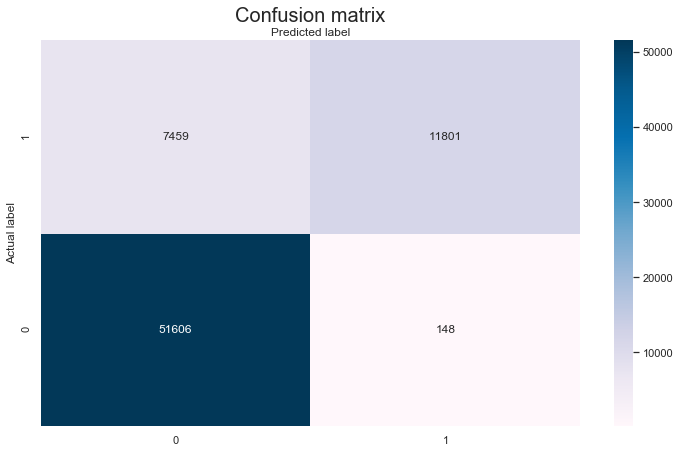

In [ ]:
print(f'Accuracy on training data: {accuracy_score(train_y, lr_train_y_pred )}')
print('')
print('Confusion Matrix')
lr_matrix_train = confusion_matrix(train_y, lr_train_y_pred)
print(lr_matrix_train)
create_confusion_matrix(lr_matrix_train)

Accuracy on validation data: 0.8914610791934212

Confusion Matrix
[[12828    43]
 [ 1884  2999]]


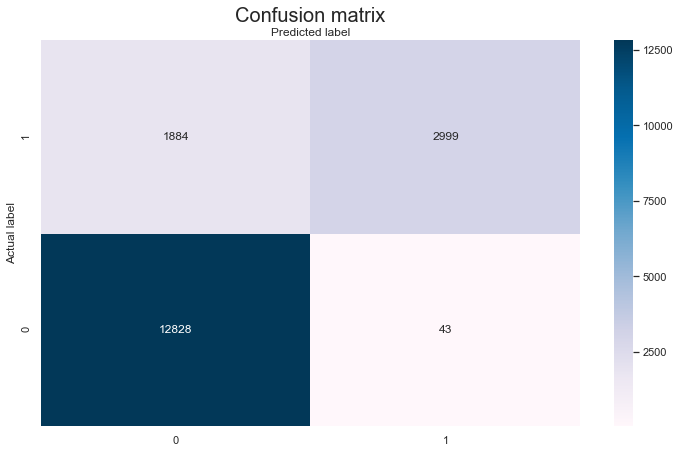

In [ ]:
print(f'Accuracy on validation data: {accuracy_score(valid_y, lr_predict(valid_X_tr))}')
print('')
print('Confusion Matrix')
lr_matrix_valid = confusion_matrix(valid_y, lr_predict(valid_X_tr))
print(lr_matrix_valid)
create_confusion_matrix(lr_matrix_valid)

Accuracy on test data: 0.89338980759699

Confusion Matrix
[[16107    50]
 [ 2316  3720]]


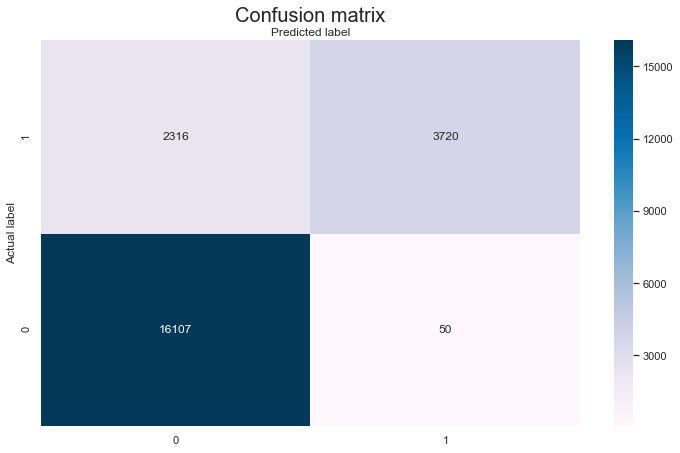

In [ ]:
print(f'Accuracy on test data: {accuracy_score( test_y, lr_predict(test_X_tr) )}')
print('')
print('Confusion Matrix')
lr_matrix_test = confusion_matrix(test_y, lr_predict(test_X_tr))
print(lr_matrix_test)
create_confusion_matrix(lr_matrix_test)

#### SVC Model

#### Use PCA to Preprocess

In [ ]:
def fit_preprocessor(x):
    """
    Returns scaler and pca fitted to given x
    """
    #scaler = MinMaxScaler().fit(x) ### ?x has to be numeric. From the above code, train_x passed into fit_preprocessor is not numeric
    scaler = full_pipe.fit(x)
    scaled_x = scaler.transform(x)
    pca = PCA(n_components=pca_components).fit(scaled_x)
    return scaler, pca

def transform(x):
    """
    Returns transformed x (scaled+pca)
    """
    scaled_x = scaler.transform(x)
    if pca_transform:
        transformed_x = pca.transform(scaled_x)
    else:
        transformed_x = scaled_x.copy()
    return transformed_x

def train_model(x,y):
    """
    Returns trained model
    """
    pre_x = transform(x)

    return SVC(C=10).fit(pre_x, y)

def predict(x):
    """
    Returns predictions
    """
    transformed_x = transform(x)
    return svc.predict(transformed_x)

In [ ]:
# SVC: fit training set X
# Note SVC don't scale so easily and its very resource intensive (especially with our dataset). So rather, we  with PCA 

train_x_pca = train_X.copy()
pca_transform = True
pca_components = 2
scaler, pca = fit_preprocessor(train_x_pca)

svc = train_model(train_x_pca,train_y)
pca.explained_variance_ratio_.cumsum()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([0.14691374, 0.27256491])

Accuracy on training data: 0.8548596051482806

Confusion Matrix
[[50972  9525]
 [  782  9735]]


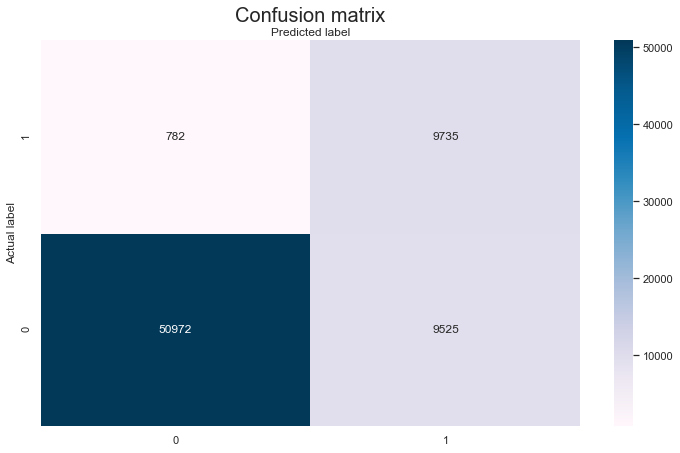

In [ ]:
print(f'Accuracy on training data: {accuracy_score(predict(train_x_pca), train_y)}')
print('')
print('Confusion Matrix')
cf_matrix_binary_train = confusion_matrix(predict(train_x_pca), train_y)
print(cf_matrix_binary_train)
create_confusion_matrix(cf_matrix_binary_train)

Accuracy on test data: 0.8531969539945028

Confusion Matrix


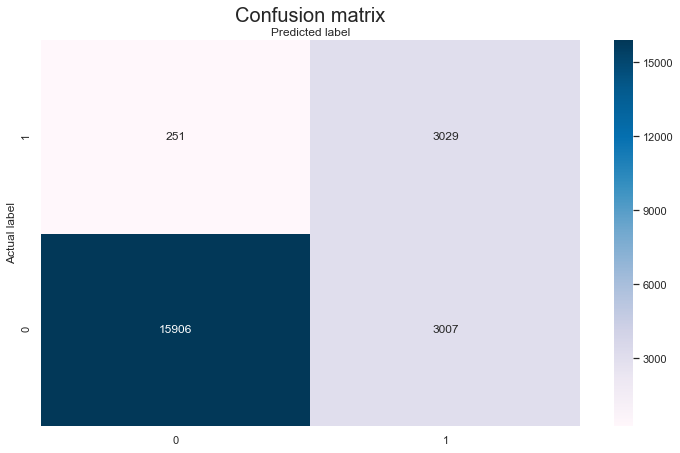

In [ ]:
print(f'Accuracy on test data: {accuracy_score(predict(test_X_tr), test_y)}')
print('')
print('Confusion Matrix')
cf_matrix_binary_test = confusion_matrix(predict(test_X_tr), test_y)
create_confusion_matrix(cf_matrix_binary_test)

Accuracy on validation data: 0.8505125605497352

Confusion Matrix


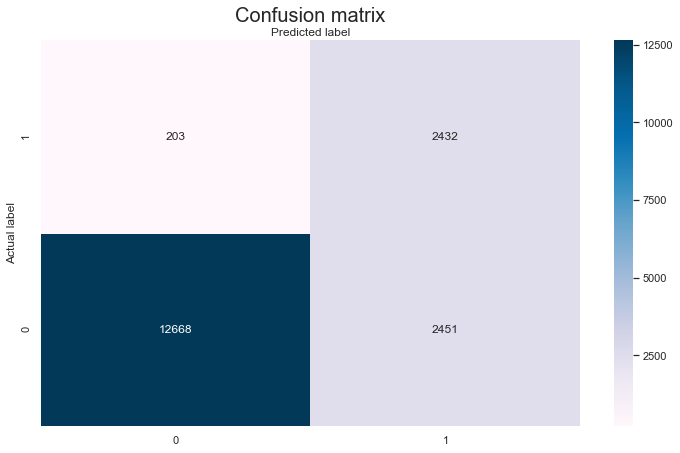

In [ ]:
print(f'Accuracy on validation data: {accuracy_score(predict(valid_X_tr), valid_y)}')
print('')
print('Confusion Matrix')
cf_matrix_binary_test = confusion_matrix(predict(valid_X_tr), valid_y)
create_confusion_matrix(cf_matrix_binary_test)

#### No PCA to Preprocess

In [ ]:
# build svc_predict model:
def svc_predict (x):
    y_pred = svc_clf.predict(x)
    return y_pred

In [ ]:
# SVC: fit training set X
# Here we use linearSVC rather than SVC since its faster
svc_clf = LinearSVC(C=10).fit(train_X_tr, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# SVC: predict training set
svc_train_y_pred = svc_predict(train_X_tr)

Accuracy on training data: 0.8170219956628271

Confusion Matrix
[[42339  9415]
 [ 3579 15681]]


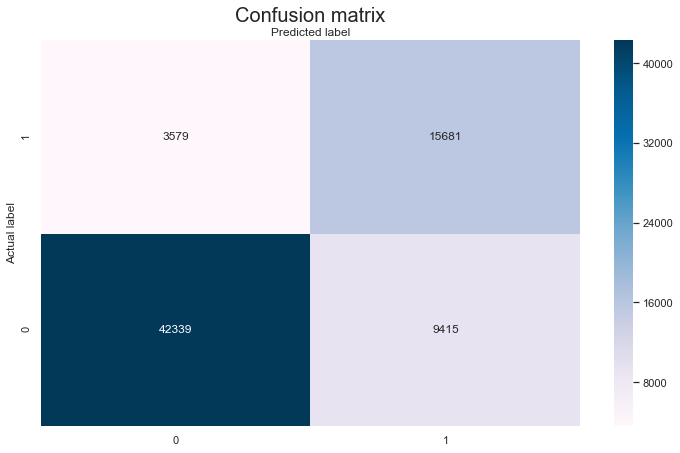

In [ ]:
print(f'Accuracy on training data: {accuracy_score(train_y, svc_predict(train_X_tr))}')
print('')
print('Confusion Matrix')
cf_matrix_binary_train = confusion_matrix(train_y, svc_predict(train_X_tr))
print(cf_matrix_binary_train)
create_confusion_matrix(cf_matrix_binary_train)

Accuracy on validation data: 0.8176185648304607

Confusion Matrix


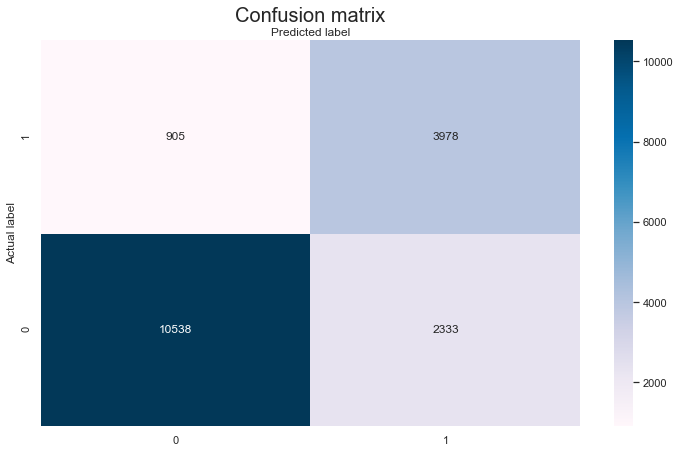

In [ ]:
print(f'Accuracy on validation data: {accuracy_score(valid_y, svc_predict(valid_X_tr))}')
print('')
print('Confusion Matrix')
cf_matrix_binary_validation = confusion_matrix(valid_y, svc_predict(valid_X_tr))

create_confusion_matrix(cf_matrix_binary_validation)

Accuracy on test data: 0.8165637813725048

Confusion Matrix


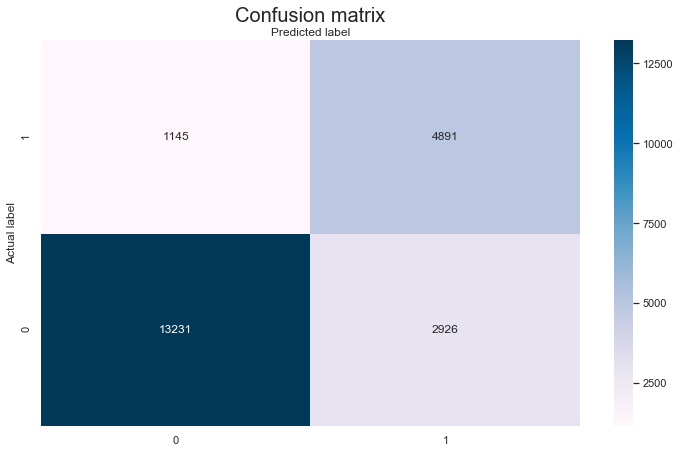

In [ ]:
print(f'Accuracy on test data: {accuracy_score(test_y, svc_predict(test_X_tr))}')
print('')
print('Confusion Matrix')
cf_matrix_binary_test = confusion_matrix(test_y, svc_predict(test_X_tr))

create_confusion_matrix(cf_matrix_binary_test)

## Supervised (Multiclass)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
# transform training, test, valication multiclass labels
train_y_enc = LabelEncoder().fit_transform(train_y_multi)
valid_y_enc = LabelEncoder().fit_transform(valid_y_multi)
test_y_enc = LabelEncoder().fit_transform(test_y_multi)

In [ ]:
pca_transform = False
pca_components = 10
scaler, pca = fit_preprocessor(train_X)

def run_model(model):  
    """
    Returns training_accuracy, test_accuracy of given model
    """
    clf = model.fit(transform(train_X), train_y_enc)
    predictions = clf.predict(transform(train_X))
    training_accuracy = accuracy_score(predictions, train_y_enc)
    print(f'Accuracy on training data: {training_accuracy}')
    
    predictions = clf.predict(transform(test_X))
    test_accuracy = accuracy_score(predictions, test_y_enc)
    print(f'Accuracy on test data: {test_accuracy}')
    
    predictions = clf.predict(transform(valid_X))
    validation_accuracy = accuracy_score(predictions, valid_y_enc)
    print(f'Accuracy on validation data: {validation_accuracy}')
    
    return training_accuracy, test_accuracy, validation_accuracy

In [ ]:
# keep track of each models
baseline = pd.DataFrame()

In [ ]:
train_acc, test_acc, validation_acc = run_model(LogisticRegression())
baseline.loc['LogisticRegression', 'train_acc'] = train_acc
baseline.loc['LogisticRegression', 'test_acc'] = test_acc
baseline.loc['LogisticRegression', 'validation_acc'] = validation_acc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on training data: 0.9179035119835526
Accuracy on test data: 0.9185328707250033
Accuracy on validation data: 0.9183282640531711


In [ ]:
# SVM takes too long with multiclass even with PCA so avoid for now
#train_acc, test_acc, validation_acc =  run_model(SVC())
#baseline.loc['SVC', 'train_acc'] = train_acc
#baseline.loc['SVC', 'test_acc'] = test_acc
#baseline.loc['SVC', 'validation_acc'] = validation_acc

In [ ]:
train_acc, test_acc, validation_acc =  run_model(DecisionTreeClassifier())
baseline.loc['DecisionTreeClassifier', 'train_acc'] = train_acc
baseline.loc['DecisionTreeClassifier', 'test_acc'] = test_acc
baseline.loc['DecisionTreeClassifier', 'validation_acc'] = validation_acc

Accuracy on training data: 0.998422846199341
Accuracy on test data: 0.9448925336817916
Accuracy on validation data: 0.9446885208966993


In [ ]:
train_acc, test_acc, validation_acc =  run_model(RandomForestClassifier(n_estimators=10))
baseline.loc['RandomForestClassifier', 'train_acc'] = train_acc
baseline.loc['RandomForestClassifier', 'test_acc'] = test_acc
baseline.loc['RandomForestClassifier', 'validation_acc'] = validation_acc

Accuracy on training data: 0.9749767651449011
Accuracy on test data: 0.9557067543820124
Accuracy on validation data: 0.9549397318914048


In [ ]:
train_acc, test_acc, validation_acc = run_model(KNeighborsClassifier(n_neighbors=5))
baseline.loc['KNeighborsClassifier', 'train_acc'] = train_acc
baseline.loc['KNeighborsClassifier', 'test_acc'] = test_acc
baseline.loc['KNeighborsClassifier', 'validation_acc'] = validation_acc

Accuracy on training data: 0.9423634776241304
Accuracy on test data: 0.9280403730906142
Accuracy on validation data: 0.9269460403289399


In [ ]:
train_acc, test_acc, validation_acc = run_model(GaussianNB())
baseline.loc['GaussianNB', 'train_acc'] = train_acc
baseline.loc['GaussianNB', 'test_acc'] = test_acc
baseline.loc['GaussianNB', 'validation_acc'] = validation_acc

Accuracy on training data: 0.5697186470273468
Accuracy on test data: 0.5730185193529491
Accuracy on validation data: 0.5731102850061958


In [ ]:
baseline

,train_acc,test_acc,validation_acc
LogisticRegression,0.917904,0.918533,0.918328
DecisionTreeClassifier,0.998423,0.944893,0.944689
RandomForestClassifier,0.974977,0.955707,0.954940
KNeighborsClassifier,0.942363,0.928040,0.926946
GaussianNB,0.569719,0.573019,0.573110


In [ ]:
def optimize_model(model, parameters, randomsearch=False):
    
    """
    Returns training_accuracy, test_accuracy of given model (optimized)
    """
    
    if randomsearch:
        clf = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_jobs=3, cv=5).fit(transform(train_X), train_y_enc)
    else:
        clf = GridSearchCV(estimator=model, param_grid=parameters, n_jobs=3, cv=5).fit(transform(train_X), train_y_enc)
    print(clf.best_estimator_)
    predictions = clf.predict(transform(train_X))
    training_accuracy = accuracy_score(predictions, train_y_enc)
    print(f'Accuracy on training data: {training_accuracy}')
    
    predictions = clf.predict(transform(test_X))
    test_accuracy = accuracy_score(predictions, test_y_enc)
    print(f'Accuracy on test data: {test_accuracy}')
    
    predictions = clf.predict(transform(valid_X))
    validation_accuracy = accuracy_score(predictions, valid_y_enc)
    print(f'Accuracy on validation data: {validation_accuracy}')
    
    return training_accuracy, test_accuracy, validation_accuracy

In [ ]:
optimized = pd.DataFrame()

In [ ]:
train_acc, test_acc, validation_acc = optimize_model(LogisticRegression(), {'penalty': ('l1', 'l2')})
optimized.loc['LogisticRegression', 'train_acc'] = train_acc
optimized.loc['LogisticRegression', 'test_acc'] = test_acc
optimized.loc['LogisticRegression', 'validation_acc'] = validation_acc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy on training data: 0.9273945982482328
Accuracy on test data: 0.9288514396431308
Accuracy on validation data: 0.9280725470316549


In [ ]:
# SVM takes too long with multiclass even with PCA so avoid for now
#train_acc, test_acc, validation_acc = optimize_model(SVC(), {'gamma': (0.1, 0.5, 1, 5, 10), 'C':(0.1, 0.5, 1, 5, 10)}, randomsearch=True)
#optimized.loc['SVC', 'train_acc'] = train_acc
#optimized.loc['SVC', 'test_acc'] = test_acc
#optimized.loc['SVC', 'validation_acc'] = validation_acc

In [ ]:
train_acc, test_acc, validation_acc = optimize_model(DecisionTreeClassifier(), {'criterion': ('gini', 'entropy'), 'max_depth':(2,3,5,10,15,20, 25, 30, 35, None), 'min_samples_leaf': (1, 2, 5,10,15,20, 25, 30, 35), 'min_samples_split': (2,3,5,10,15,20, 25, 30, 35), 'max_features': ('auto', 'sqrt', 'log2', None)}, randomsearch=True)

optimized.loc['DecisionTreeClassifier', 'train_acc'] = train_acc
optimized.loc['DecisionTreeClassifier', 'test_acc'] = test_acc
optimized.loc['DecisionTreeClassifier', 'validation_acc'] = validation_acc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=25,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=35, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Accuracy on training data: 0.9573746021911173
Accuracy on test data: 0.957373946739963
Accuracy on validation data: 0.9576433479779205


In [ ]:
train_acc, test_acc, validation_acc = optimize_model(RandomForestClassifier(), {'n_estimators': (2,5,7,10,12,15,18,20), 'criterion': ('gini', 'entropy'), 'max_depth':(2,3,5,10,15,20, 25, 30, 35, None), 'min_samples_leaf': (1, 2, 5,10,15,20, 25, 30, 35), 'min_samples_split': (2,3,5,10,15,20, 25, 30, 35), 'max_features': ('auto', 'sqrt', 'log2', None)}, randomsearch=True)
optimized.loc['RandomForestClassifier', 'train_acc'] = train_acc
optimized.loc['RandomForestClassifier', 'test_acc'] = test_acc
optimized.loc['RandomForestClassifier', 'validation_acc'] = validation_acc

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy on training data: 0.9613456501534908
Accuracy on test data: 0.9605280944441941
Accuracy on validation data: 0.9609665427509294


In [ ]:
train_acc, test_acc, validation_acc = optimize_model(KNeighborsClassifier(n_jobs=3), {'n_neighbors': [2,100], 'weights': ('uniform', 'distance'), 'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'), 'p': [2,10]}, randomsearch=True)
optimized.loc['KNeighborsClassifier', 'train_acc'] = train_acc
optimized.loc['KNeighborsClassifier', 'test_acc'] = test_acc
optimized.loc['KNeighborsClassifier', 'validation_acc'] = validation_acc

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=3, n_neighbors=100, p=10,
                     weights='distance')
Accuracy on training data: 0.998422846199341
Accuracy on test data: 0.9288514396431308
Accuracy on validation data: 0.9273966430100259


In [ ]:
train_acc, test_acc,validation_acc  = optimize_model(GaussianNB(), {'var_smoothing': [1e-12, 1e-7]}, randomsearch=True)
optimized.loc['GaussianNB', 'train_acc'] = train_acc
optimized.loc['GaussianNB', 'test_acc'] = test_acc
optimized.loc['GaussianNB', 'validation_acc'] = validation_acc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


GaussianNB(priors=None, var_smoothing=1e-12)
Accuracy on training data: 0.5958825020418509
Accuracy on test data: 0.5995584193214076
Accuracy on validation data: 0.5980624084713304


In [ ]:
optimized

,train_acc,test_acc,validation_acc
LogisticRegression,0.927395,0.928851,0.928073
DecisionTreeClassifier,0.957375,0.957374,0.957643
RandomForestClassifier,0.961346,0.960528,0.960967
KNeighborsClassifier,0.998423,0.928851,0.927397
GaussianNB,0.595883,0.599558,0.598062


In [ ]:
clf1 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
#clf2 = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
#    max_iter=-1, probability=True, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)
clf3 = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=25,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=35, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
clf4 = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=25, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
clf5 = KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=3, n_neighbors=100, p=10,
                     weights='distance')

In [ ]:
# using voting classifier
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('dt', clf3), ('rf', clf4), ('knn', clf5)], voting='soft').fit(transform(train_X), train_y_enc)
predictions = eclf1.predict(transform(train_X))
training_accuracy = accuracy_score(predictions, train_y_enc)
print(f'Accuracy on training data: {training_accuracy}')

predictions = eclf1.predict(transform(test_X))
test_accuracy = accuracy_score(predictions, test_y_enc)
print(f'Accuracy on test data: {test_accuracy}')

predictions = eclf1.predict(transform(valid_X))
validation_accuracy = accuracy_score(predictions, valid_y_enc)
print(f'Accuracy on validation data: {validation_accuracy}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on training data: 0.9613456501534908
Accuracy on test data: 0.9476862073626819
Accuracy on validation data: 0.9464909316210431
